In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
#from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from quetzal.model import stepmodel
from quetzal.io import excel

# Validate different scenarios against each other

In [2]:
# Resolution of output plots
dpi = 600

In [3]:
# Define the mode colors
cmap_mode = get_cmap('CMRmap')
colormap = {'car':cmap_mode(.45), 'private_car':cmap_mode(.45), 'car_sharing':cmap_mode(.51),
            'rail':cmap_mode(.24), 'rail_long':cmap_mode(.3), 'rail_short':cmap_mode(.24),
            'coach':cmap_mode(.8), 'bus':cmap_mode(.73),
            'air':cmap_mode(.02), 'air_domestic':cmap_mode(.02),
            'non-motorised':cmap_mode(.93)
           } # also defines mode order

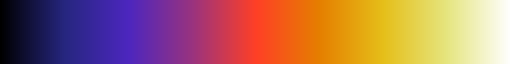

In [4]:
cmap_mode

In [5]:
# Choose scenarios !
scenario_ref = 'base'
scenarios = [scenario_ref] + ['ref_35', 'policy_35'] #or use other scenarios like: ['Avoid', 'Shift', 'Avoid+Shift']

In [6]:
# Choose colors for scenario comparison, must be asjusted if more than ca. 8 scenarios in total
cmap = get_cmap('magma') # or cividis

# Scenario colors, for each scenario one
dark_scen = .25
colors_scenarios = {}
for idx, scen in enumerate(scenarios):
    colors_scenarios[scen] = cmap(dark_scen + idx * .20)
colors_inter = colors_scenarios

# Colors for later comparison of inner- and inter-zonal volumes by segment
dark_inner = .3
colors_inner = {}
for idx, scen in enumerate(scenarios):
    colors_inner[scen] = cmap(dark_inner + idx * .20)

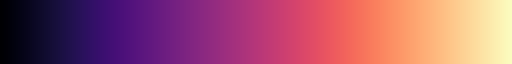

In [7]:
cmap

In [8]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'
params = excel.read_var(file='../input/parameters.xls', scenario=scenario_ref)
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = [s.split('_')[0] for s in segments][::2]

In [9]:
ref = stepmodel.read_json(model_path + scenario_ref + '/de_zones')
ref.zones = gpd.GeoDataFrame(ref.zones, crs=ref.epsg)

In [10]:
# Load distances
distances = pd.read_csv(output_path + '/distances_centroids.csv')
distances = distances.set_index(['origin', 'destination'])

In [11]:
# Load the calibration dataset for validation
if False:
    mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_all_trips_MiD2017.csv')
    # Replace LAU codes with NUTS IDs
    assert str(mid2017.loc[0, 'origin']).startswith('DE')
    # Rename modes and purposes
    mode_dict_mid = {1: 'rail_short', 2: 'rail_long',
                     3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
    mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
    mid2017['purpose_model'] = mid2017['purpose_model'].apply(lambda s: s.split('_')[0])
    mid2017['segment'] = mid2017['purpose_model'] + mid2017['car_avail'].map(
        {1: '_car', 0: '_no_car', 9: '_no_car'})
    mid2017 = mid2017[['mode_model', 'purpose_model', 'segment', 'origin', 'destination']]

# Composite cost

Percieved cost averaged over all modes by origin-destination pair

In [12]:
# Load CC
cc = {}
for scenario in scenarios:
    cc[scenario] = pd.read_csv(output_path + scenario + '/mode_choice_od_composite_cost.csv')

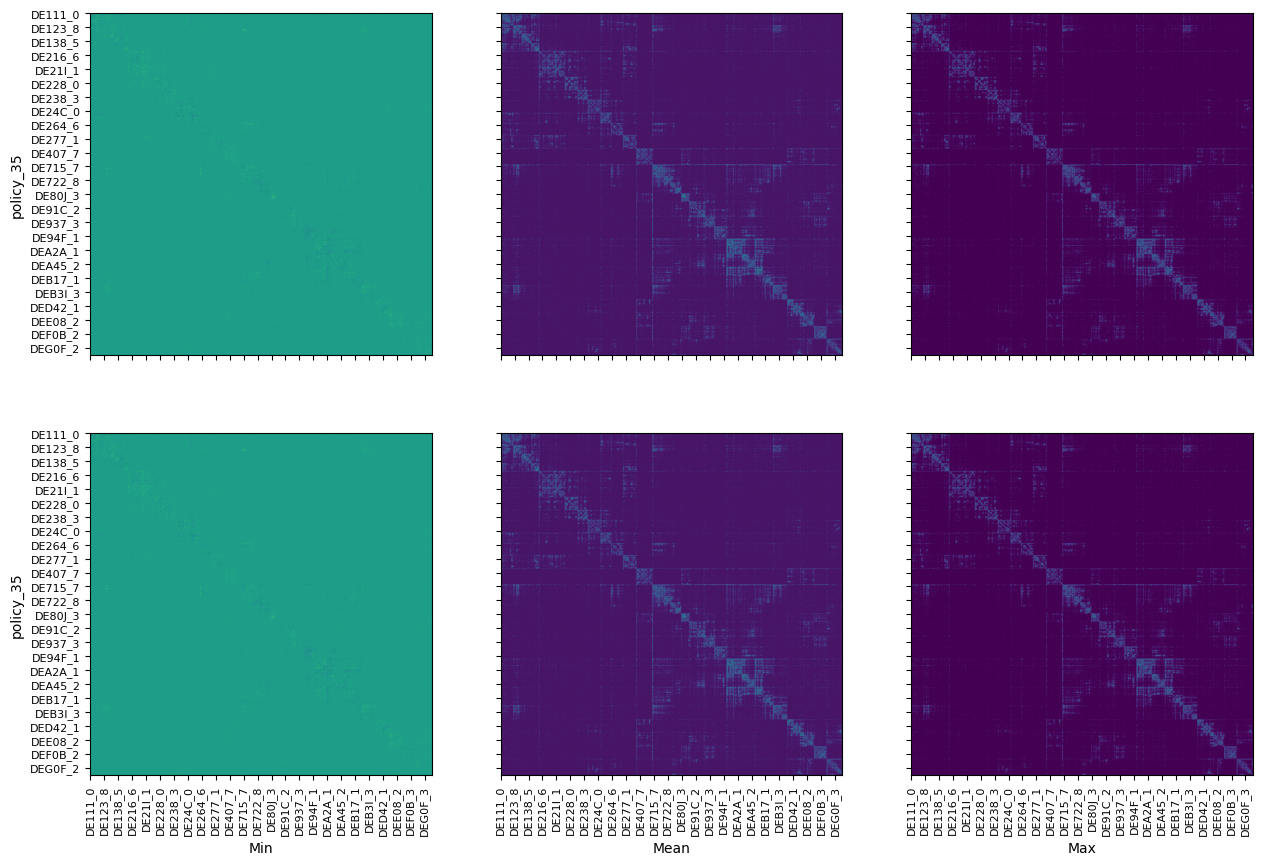

In [13]:
# Differences to reference scenario
fig, ax = plt.subplots(nrows=len(scenarios)-1, ncols=3, figsize=(15,(len(scenarios)-1)*5),
                       sharex='all', sharey='all')
label_step = 90
ref_matrix = cc[scenario_ref].set_index(['origin', 'destination']).min(axis=1).unstack('destination')
try:
    for i in range(1, len(scenarios)):
        i -= 1
        ax[i,0].set_ylabel(scenario)
        matrix = cc[scenario].set_index(['origin', 'destination']).min(axis=1).unstack('destination')
        ax[i,0].imshow((matrix - ref_matrix).fillna(0).values)
        matrix = cc[scenario].set_index(['origin', 'destination']).mean(axis=1).unstack('destination')
        ax[i,1].imshow((matrix - ref_matrix).fillna(0).values)
        matrix = cc[scenario].set_index(['origin', 'destination']).max(axis=1).unstack('destination')
        ax[i,2].imshow((matrix - ref_matrix).fillna(0).values)
        ylabels = list(matrix.columns)
        ax[i,0].set_yticks(range(0, len(ylabels), label_step), labels=ylabels[::label_step], fontsize=8)
        if i == len(scenarios)-2:
            xlabels = list(matrix.index)
            ax[i,0].set_xticks(range(0, len(xlabels), label_step), labels=xlabels[::label_step], fontsize=8, rotation=90)
            ax[i,1].set_xticks(range(0, len(xlabels), label_step), labels=xlabels[::label_step], fontsize=8, rotation=90)
            ax[i,2].set_xticks(range(0, len(xlabels), label_step), labels=xlabels[::label_step], fontsize=8, rotation=90)
            ax[i,0].set_xlabel('Min')
            ax[i,1].set_xlabel('Mean')
            ax[i,2].set_xlabel('Max')
except IndexError:
    print('too few scenarios for this plot')

In [14]:
# Define distance classes
#bins = [0, 20, 40, 60, 80, 100, 150, 200, 300, 500, 700, 1000]
#labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]
bins = list(range(0,1020, 10))
labels = bins[:-1]
for scenario in scenarios:
    cc[scenario]['dist'] = cc[scenario].set_index(['origin', 'destination']).index.map(distances.to_dict()['length'])
    cc[scenario]['bins'] = pd.cut(cc[scenario]['dist'], bins=bins, labels=labels)

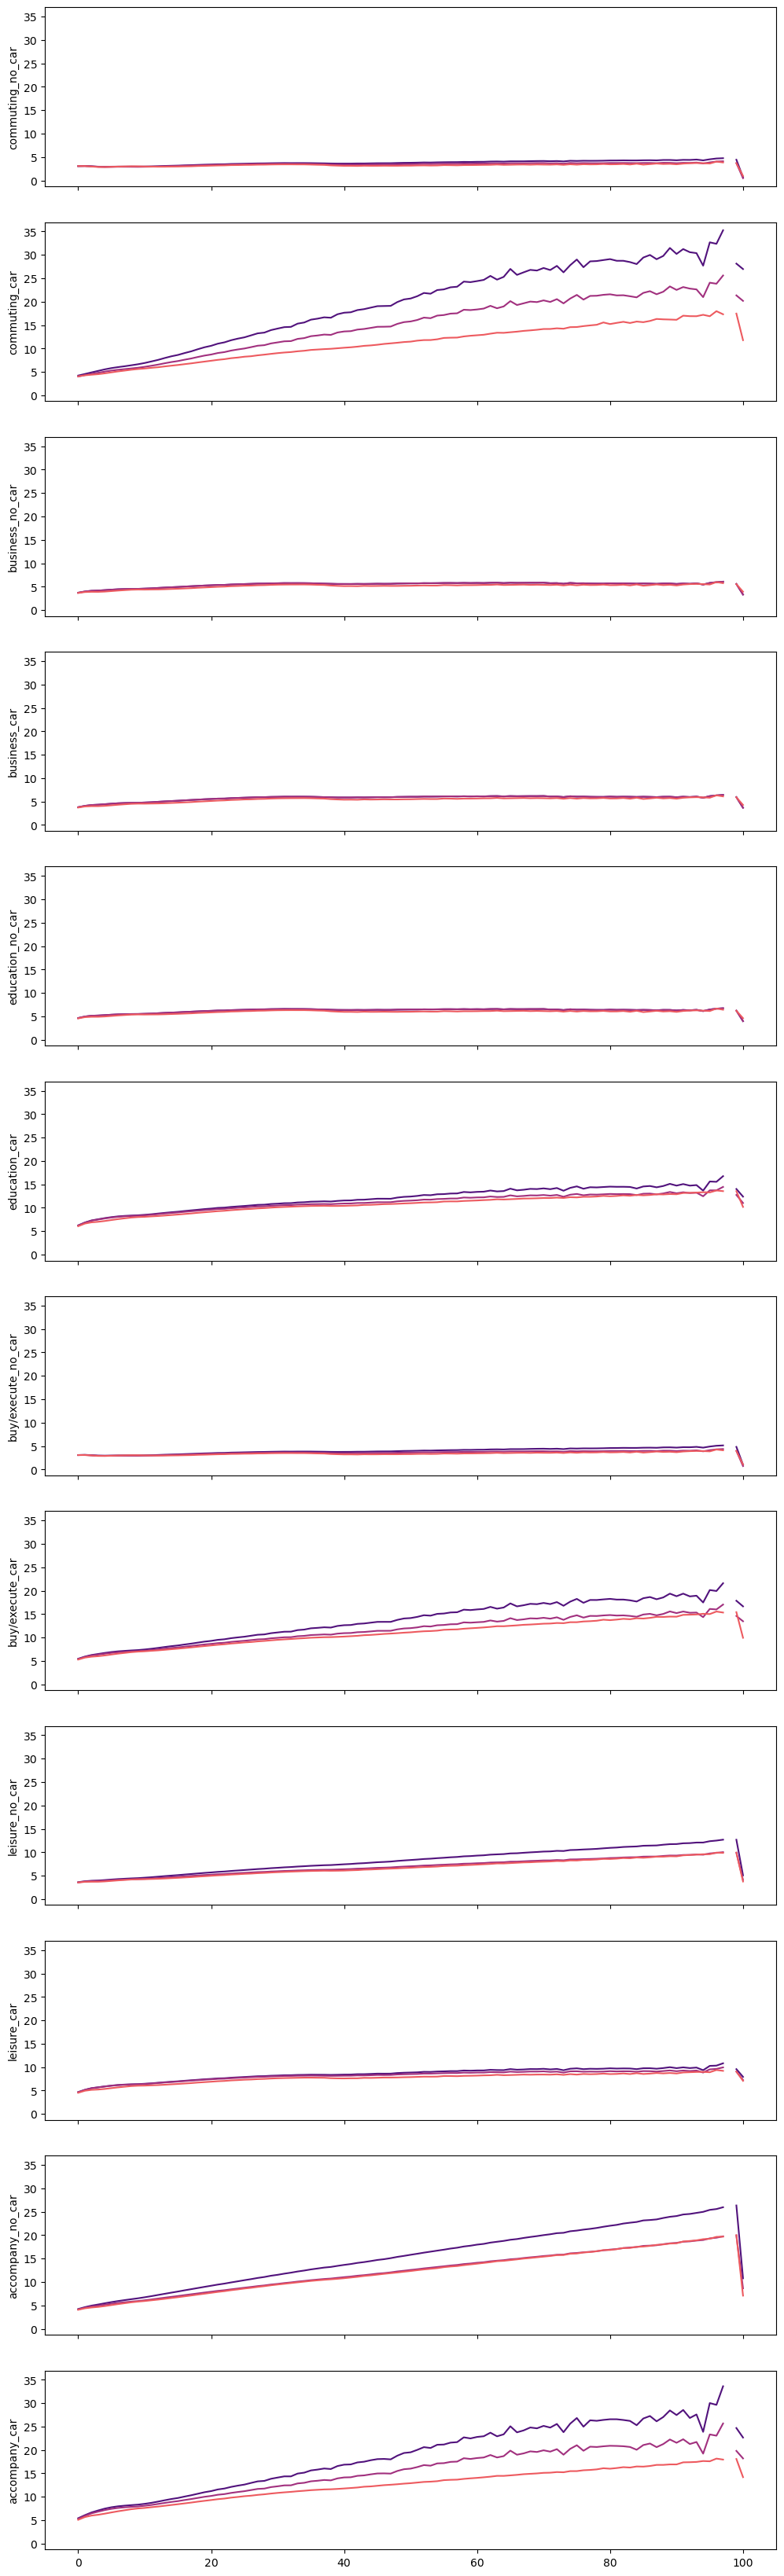

In [15]:
fig, ax = plt.subplots(nrows=len(segments), ncols=1, figsize=(12, 3.5*len(segments)),
                       sharex='all', sharey='all')
i = 0
for seg in segments:
    for scenario in scenarios:
        ax[i].plot(np.arange(len(labels)), cc[scenario].loc[
            cc[scenario].notna().all(axis=1)].groupby('bins')[seg].mean(),
                  color=colors_scenarios[scenario])
    ax[i].set_ylabel(seg)
    i += 1

Text(0, 0.5, 'Max')

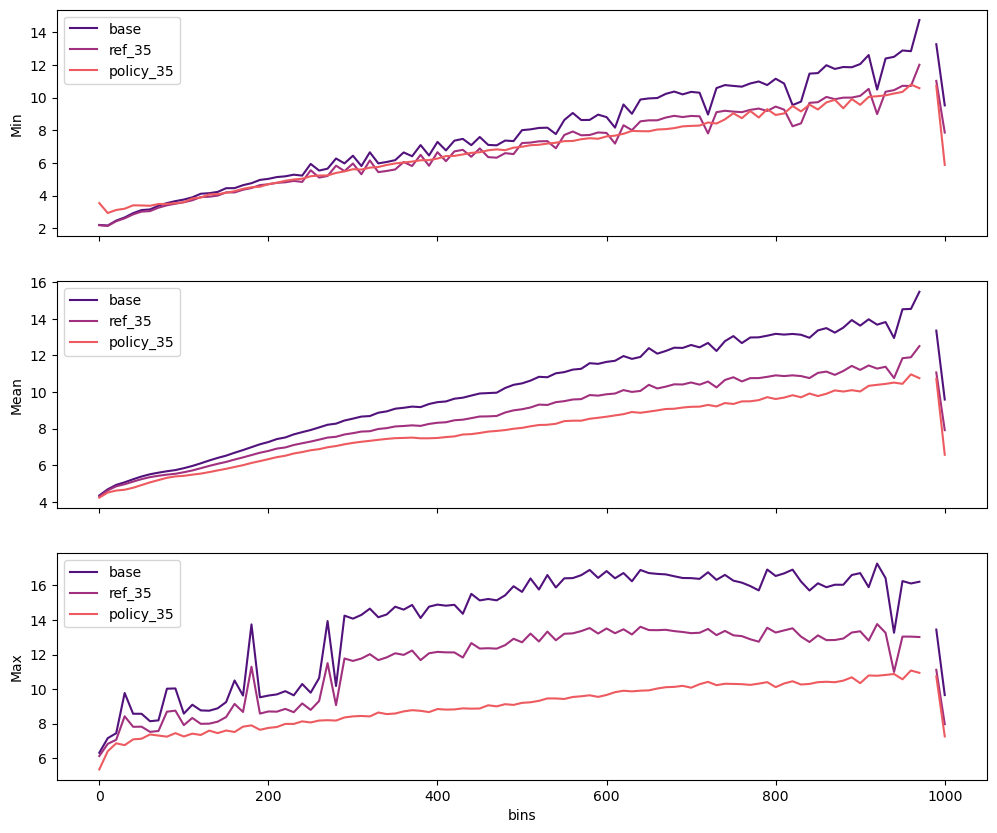

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,10),
                       sharex='all', sharey='row')
for scenario in scenarios:
    cc[scenario].loc[cc[scenario].notna().all(axis=1)].groupby('bins')[segments].min().mean(axis=1).plot.line(
        legend=True, label=scenario, color=colors_scenarios[scenario], ax=ax[0])
    cc[scenario].loc[cc[scenario].notna().all(axis=1)].groupby('bins')[segments].mean().mean(axis=1).plot.line(
        legend=True, label=scenario, color=colors_scenarios[scenario], ax=ax[1])
    cc[scenario].loc[cc[scenario].notna().all(axis=1)].groupby('bins')[segments].max().mean(axis=1).plot.line(
        legend=True, label=scenario, color=colors_scenarios[scenario], ax=ax[2])
ax[0].set_ylabel('Min')
ax[1].set_ylabel('Mean')
ax[2].set_ylabel('Max')

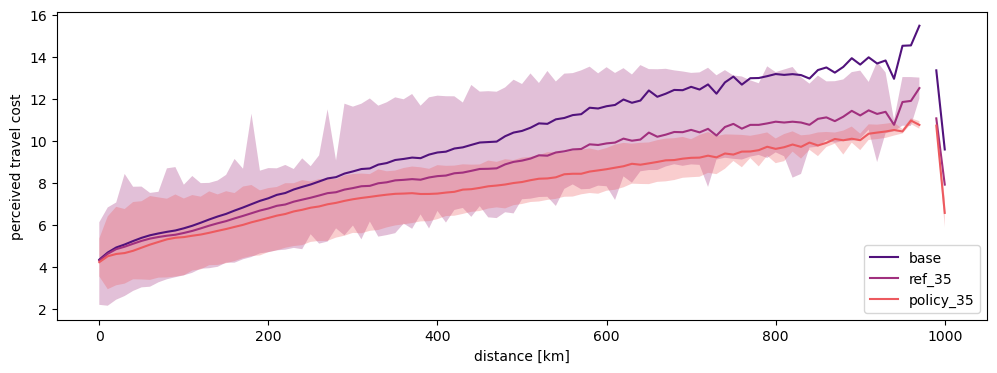

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4),
                       sharex='all', sharey='row')
ind = labels
for scenario in scenarios:
    mean_cc = cc[scenario].loc[cc[scenario].notna().all(axis=1)].groupby('bins')[segments].mean().mean(axis=1)
    ax.plot(ind, mean_cc, label=scenario, color=colors_scenarios[scenario])
    if scenario != scenario_ref:
        min_cc = cc[scenario].loc[cc[scenario].notna().all(axis=1)].groupby('bins')[segments].min().mean(axis=1)
        max_cc = cc[scenario].loc[cc[scenario].notna().all(axis=1)].groupby('bins')[segments].max().mean(axis=1)
        ax.fill_between(ind, mean_cc, min_cc, facecolor=colors_scenarios[scenario], alpha=0.3)
        ax.fill_between(ind, mean_cc, max_cc, facecolor=colors_scenarios[scenario], alpha=0.3)
ax.set_ylabel('perceived travel cost')
ax.set_xlabel('distance [km]')
ax.legend(loc='lower right')
#plt.savefig(output_path + '_scenario_validation/cc_all_distance_minmax.png', dpi=dpi)

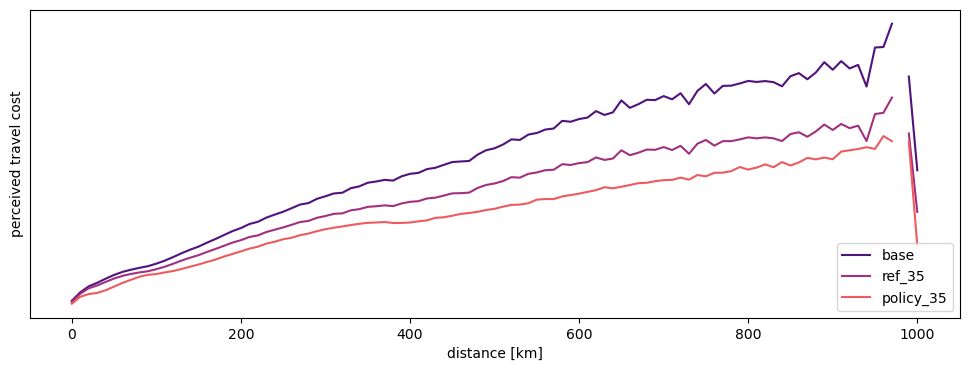

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4),
                       sharex='all', sharey='row')
ind = labels
for scenario in scenarios:
    mean_cc = cc[scenario].loc[cc[scenario].notna().all(axis=1)].groupby('bins')[segments].mean().mean(axis=1)
    ax.plot(ind, mean_cc, label=scenario, color=colors_scenarios[scenario])
ax.set_ylabel('perceived travel cost')
ax.set_yticks([])
ax.set_xlabel('distance [km]')
ax.legend(loc='lower right')
plt.savefig(output_path + '_scenario_validation/cc_all_distance.png', dpi=dpi)

Text(0.5, 0, 'distance [km]')

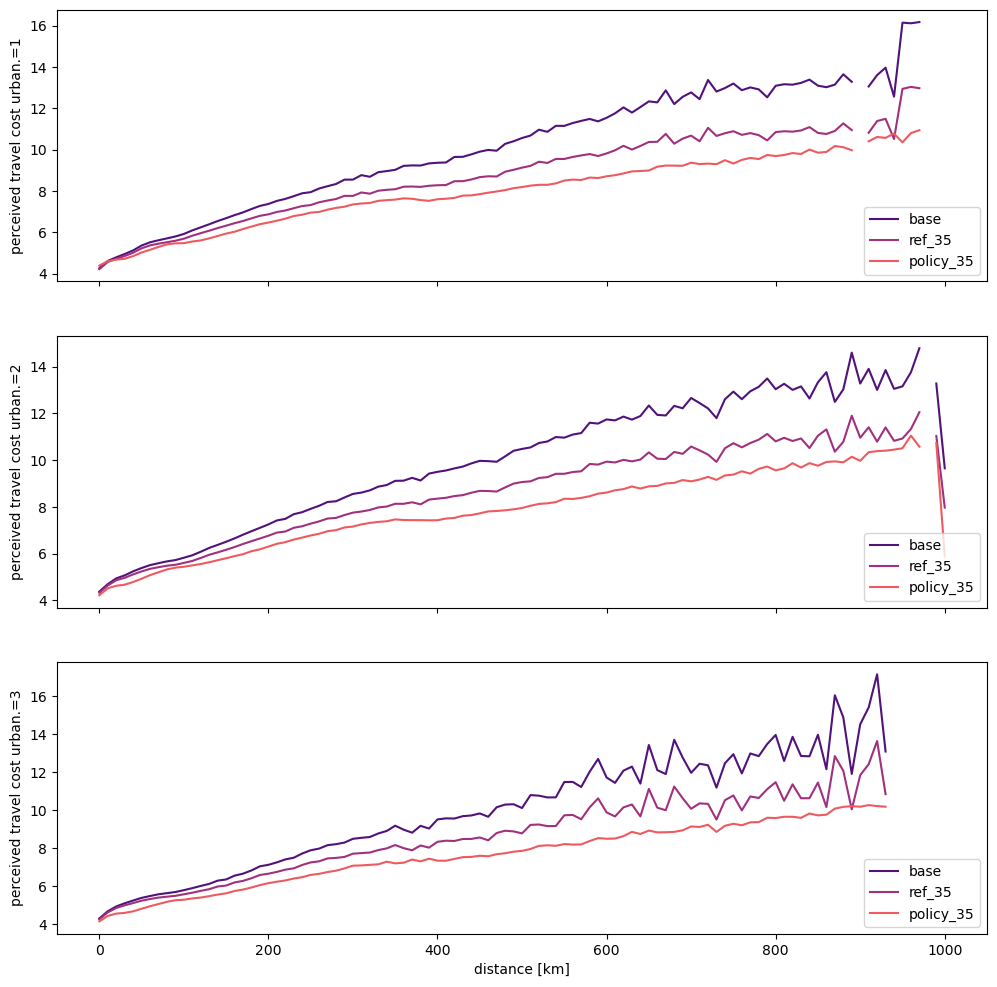

In [19]:
# By urbanisation
urb = list(ref.zones['urbanisation'].unique())
urb.sort()
fig, ax = plt.subplots(nrows=len(urb), ncols=1, figsize=(12,4*len(urb)),
                       sharex='all', sharey='row')
ind = labels
for u in urb:
    zones = list(ref.zones.loc[ref.zones['urbanisation']==u].index)
    for scenario in scenarios:
        mean_cc = cc[scenario].loc[(cc[scenario].notna().all(axis=1)) & (cc[scenario]['origin'].isin(zones))
                                  ].groupby('bins')[segments].mean().mean(axis=1)
        ax[u-1].plot(ind, mean_cc, label=scenario, color=colors_scenarios[scenario])
    ax[u-1].set_ylabel('perceived travel cost urban.={}'.format(u))
    ax[u-1].legend(loc='lower right')
ax[-1].set_xlabel('distance [km]')
#plt.savefig(output_path + '_scenario_validation/cc_all_distance_urbanisation.png', dpi=dpi)

# Volumes

Number of trips per year

In [20]:
# Load volumes
vols = {}
for scenario in scenarios:
    vols[scenario] = stepmodel.read_zippedpickles(model_path + scenario + '/de_volumes')

volumes: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  9.74it/s]


In [21]:
# Inner- and inter-zonal volumes by segment
seg_df = pd.DataFrame()
for scenario in scenarios:
    vol = vols[scenario].volumes
    seg_df[scenario+'_inner'] = vol.loc[vol['origin']==vol['destination'], segments].sum()
    seg_df[scenario+'_inter'] = vol.loc[vol['origin']!=vol['destination'], segments].sum()

<Axes: >

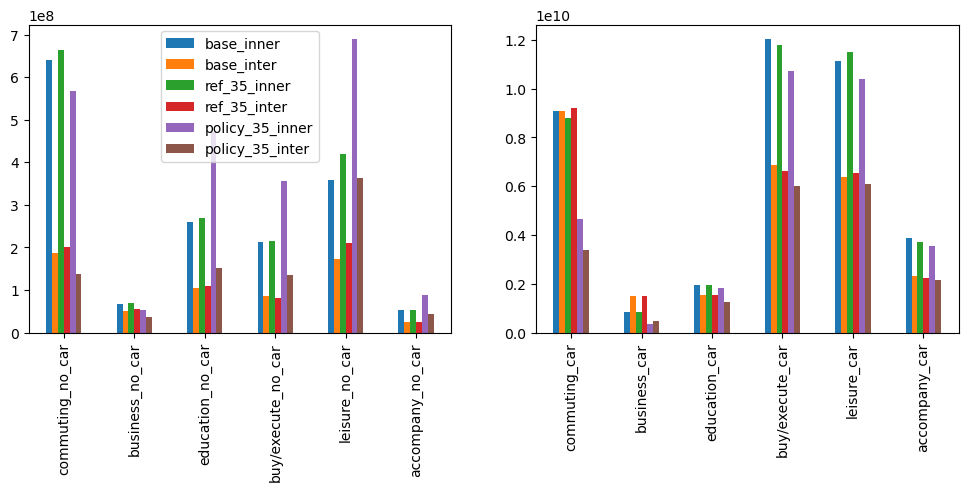

In [22]:
# Compare inner- and inter-zonal volumes by segment
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
seg_df.loc[[s for s in segments if '_no_car' in s]].plot.bar(legend=True, ax=ax[0])
seg_df.loc[[s for s in segments if not '_no_car' in s]].plot.bar(legend=False, ax=ax[1])

In [23]:
# Share of inter-zonal trips in reference
seg_df[scenario_ref + '_inter'].sum() / (seg_df[scenario_ref + '_inner'].sum() + seg_df[scenario_ref + '_inter'].sum())

0.4116641541974538

In [24]:
# total trips
for scenario in scenarios:
    print("{}: {} bn.".format(scenario, round(seg_df[
        [scenario+suffix for suffix in ['_inter', '_inner']]].sum().sum() / 1e9, 1)))

base: 68.8 bn.
ref_35: 68.6 bn.
policy_35: 54.0 bn.


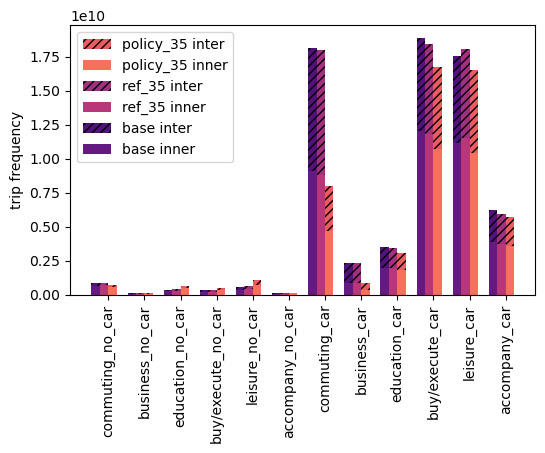

In [25]:
# Compare inner- and inter-zonal volumes by segment
# Stacked bar plot: inner+inter by scenario by segment
# Colors are set at the beginning of this notebook
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3.5))
segs = [s for s in segments if '_no_car' in s]+[s for s in segments if not '_no_car' in s]
ind = np.arange(len(segments))
width = 1/len(scenarios) - 0.1
width_filled = 0
for scenario in scenarios:
    ax.bar(ind+width_filled-width*1.5, seg_df.loc[segs, scenario+'_inner'].values,
           bottom=0, width=width,
           label=scenario+' inner',
           color=[colors_inner[scenario] for _ in segments])
    ax.bar(ind+width_filled-width*1.5, seg_df.loc[segs, scenario+'_inter'].values,
           bottom=seg_df.loc[segs, scenario+'_inner'].values,
           width=width,
           label=scenario+' inter',
           hatch='////',
           color=[colors_inter[scenario] for _ in segments])
    width_filled += width
ax.set_ylabel('trip frequency')
ax.set_xticks(ind, segs, rotation=90)
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-1], l[::-1])
plt.savefig(output_path + '_scenario_validation/inner-inter_shares.png', dpi=dpi, bbox_inches="tight")

### Distance distribution

inter-zonal trips

In [26]:
# Define distance classes
#bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 300, 500, 1000]
#labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]
bins = list(range(0,1020, 10))
labels = bins[:-1]
for scenario in scenarios:
    vol = vols[scenario].volumes
    vol['dist'] = vol.set_index(['origin', 'destination']).index.map(distances.to_dict()['length'])
    vol['bins'] = pd.cut(vol['dist'], bins=bins, labels=labels)

In [27]:
# Sum up volumes
vol_df = pd.DataFrame()
for scenario in scenarios:
    vol_df[[scenario+' '+seg for seg in segments]] = vols[scenario].volumes.groupby('bins')[segments].sum()
    vol_df[scenario] = vol_df[[scenario+' '+seg for seg in segments]].sum(axis=1)
    vol_df[scenario+' sum with car'] = vol_df[[scenario+' '+seg for seg in segments if not '_no_car' in seg]].sum(axis=1)
    vol_df[scenario+' sum without car'] = vol_df[[scenario+' '+seg for seg in segments if '_no_car' in seg]].sum(axis=1)

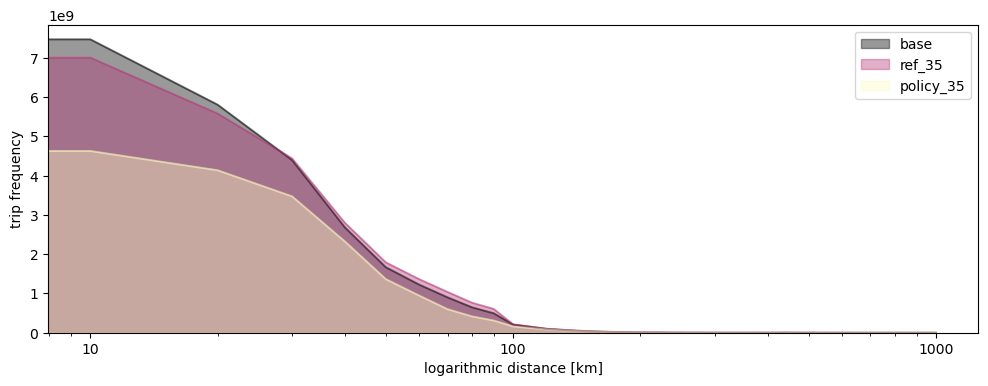

In [28]:
# plot total
ax = vol_df[[s for s in scenarios]].plot(kind='area', stacked=False, logx=True,
                                         alpha=.4, colormap=cmap, figsize=(12,4))
ax.set_xlabel('logarithmic distance [km]')
ax.set_ylabel('trip frequency')
'''# zoom into longer trips
x1 = 200
x2 = 1000
y1 = 0
y2 = 1e6
axins = zoomed_inset_axes(ax, 2, loc=1) # zoom = 2
vol_df[[s for s in scenarios]].plot(kind='area', stacked=False, logx=True,
                                    alpha=.4, colormap=cmap, ax=axins)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")'''

plt.savefig(output_path + '_scenario_validation/distance_distribution_total.png', dpi=dpi)

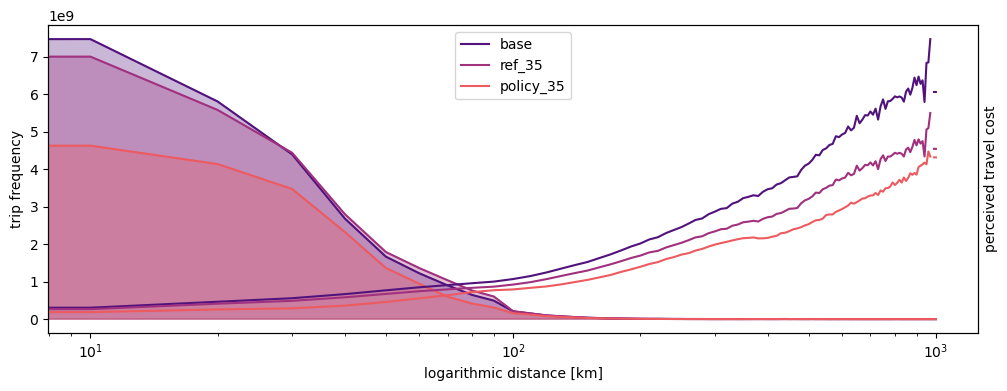

In [29]:
# plot with CC
fig, ax1 = plt.subplots(figsize=(12,4))
ind = list(range(0,1020, 10))[:-1]
for scenario in scenarios:
    ax1.plot(ind, vol_df[scenario], color=colors_scenarios[scenario])
    ax1.fill_between(ind, 0, vol_df[scenario], color=colors_scenarios[scenario], alpha=.3)
ax1.set_ylabel('trip frequency')

ax2 = ax1.twinx()
for scenario in scenarios:
    mean_cc = cc[scenario].loc[cc[scenario].notna().all(axis=1)
                              ].groupby('bins')[segments].mean().mean(axis=1)
    mean_cc[1000] = mean_cc[990]
    ax2.plot(ind, mean_cc,
             label=scenario, color=colors_scenarios[scenario])
ax2.set_ylabel('perceived travel cost')
ax2.set_yticks([])

ax1.set_xlabel('logarithmic distance [km]')
ax1.set_xscale('log')
#ax_upper = ax1.secondary_xaxis('top')
#ax_upper.set_xlabel('perceived travel cost: distance [km]')
ax2.legend(loc='upper center')
plt.savefig(output_path + '_scenario_validation/distance_distribution_total_cc.png', dpi=dpi)

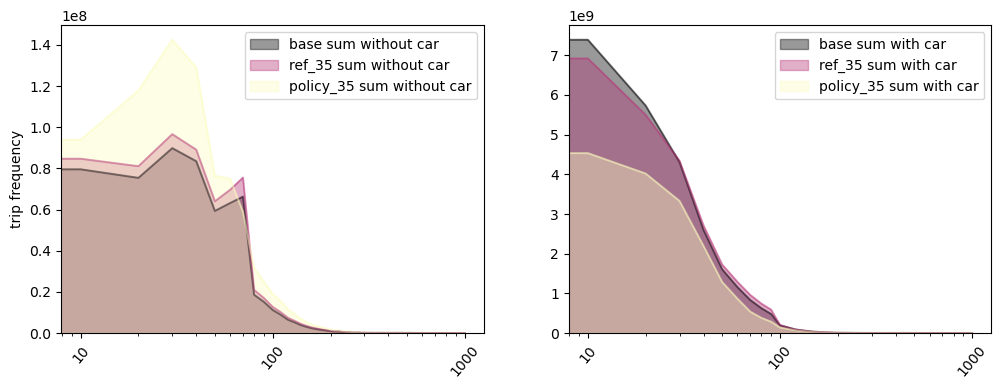

In [30]:
# plot by car availability
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
vol_df[[s+' sum without car' for s in scenarios]].plot(kind='area', stacked=False, logx=True,
                                                       colormap=cmap, alpha=.4, ax=ax[0])
vol_df[[s+' sum with car' for s in scenarios]].plot(kind='area', stacked=False, logx=True,
                                                    colormap=cmap, alpha=.4, ax=ax[1])
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[0].set_ylabel('trip frequency')
ax[0].tick_params(axis="x", rotation=50)
ax[1].tick_params(axis="x", rotation=50)
plt.savefig(output_path + '_scenario_validation/distance_distribution_car_ownership.png', dpi=dpi)

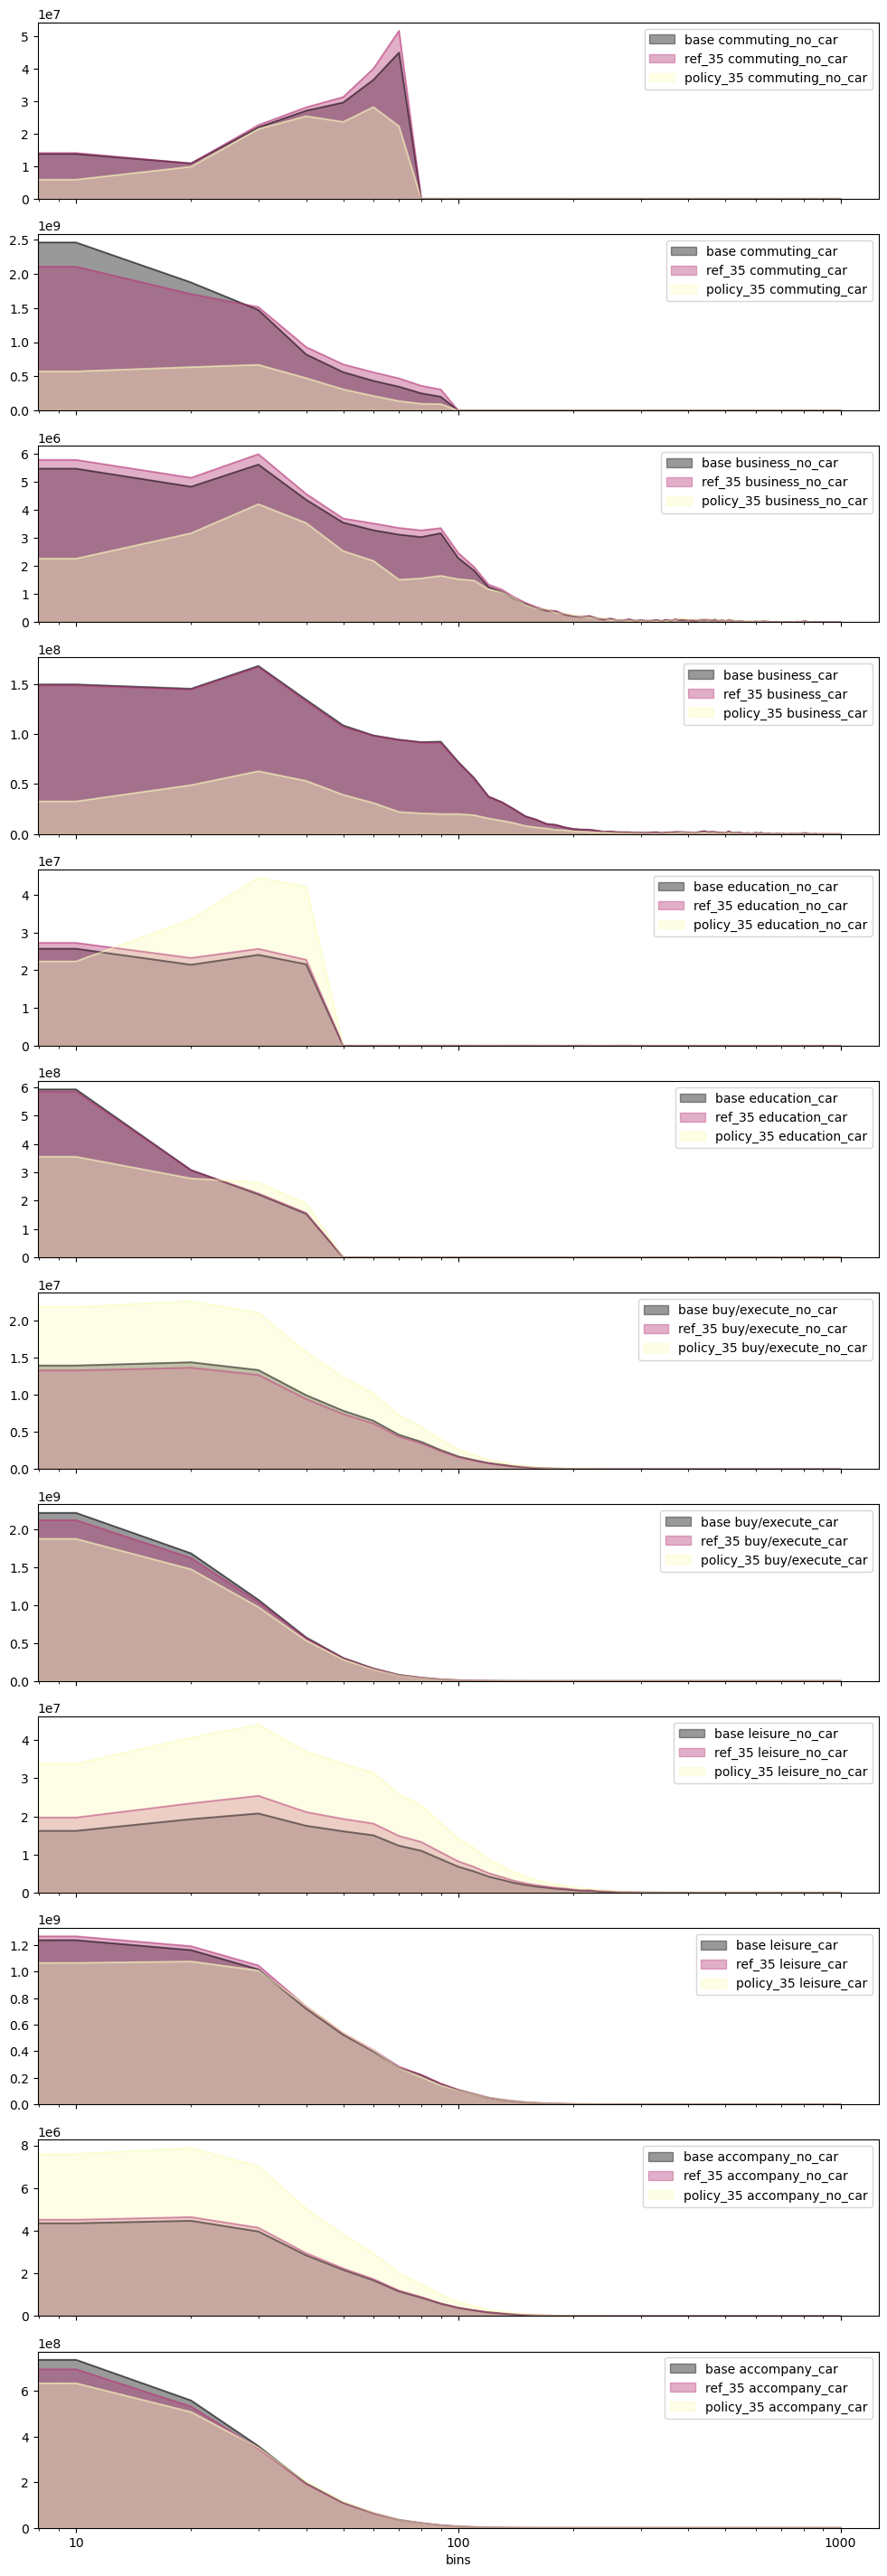

In [31]:
# plot by segment
fig, ax = plt.subplots(ncols=1, nrows=len(segments), figsize=(12,len(segments)*3), sharex='all')
i = 0
for seg in segments:
    vol_df[[scenario+' '+seg for scenario in scenarios]].plot(kind='area', stacked=False, logx=True,
                                                              colormap=cmap, alpha=.4, ax=ax[i])
    i += 1

# Modal split

by main mode. Inter-zonal (i.e. no local transport)

In [32]:
# Load probabilities and merge with volumes to create an OD matrix
ods = {}
for scenario in scenarios:
    # inter-zonal
    sm = stepmodel.read_zippedpickles(model_path + scenario + '/de_logit')
    od = sm.probabilities.set_index(['origin', 'destination', 'segment'])\
        .drop(columns=['root'], errors='ignore').unstack('segment')
    modes = set(od.columns.get_level_values(0))
    if len(['rail' for mode in modes if 'rail' in mode]) > 1:
        od.drop('rail', axis=1, inplace=True)
    if len(['car' for mode in modes if 'car' in mode]) > 1:
        od.drop('car', axis=1, inplace=True)
    vol = vols[scenario].volumes.loc[
        vols[scenario].volumes['origin']!=vols[scenario].volumes['destination']
    ].set_index(['origin', 'destination']).drop(columns=['bins', 'dist', 'index'], errors='ignore')
    for mode in set(od.columns.get_level_values(0)):
        od[mode] = od[mode] * vol
    ods[scenario] = od
    assert np.round(od.sum().sum(), 0) == np.round(vol.sum().sum(), 0), \
        'Mode choice probabilities do not sum up to one per OD pair and segment'
    del sm
    # inner-zonal
    #inner = pd.read_excel(output_path + scenario + '/inner-zone.xlsx', sheet_name='agg')
    #inner

probabilities: 100%|██████████████████████████████| 7/7 [00:01<00:00,  3.84it/s]


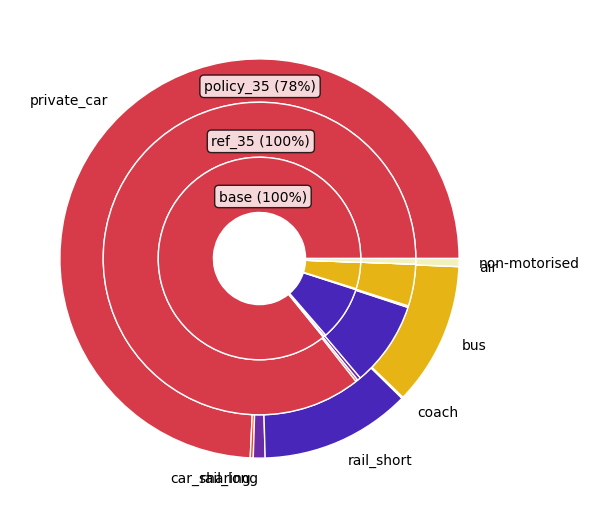

In [33]:
# Modal split total between zones
# Layer thickness represents total volumes between zones
# Multiple ring plot
fig, ax = plt.subplots(figsize=(6,6), layout='tight')
ref_trips_sum = seg_df[[scenario_ref+suffix for suffix in ['_inter', '_inner']]].sum().sum()
width_sum = sum([seg_df[[scenario+suffix for suffix in ['_inter', '_inner']]].sum().sum()
                 for scenario in scenarios]) * 1.3 # for empty space in the middle
width_filled = 0
for scenario in scenarios[::-1]:
    width = seg_df[[scenario+suffix for suffix in ['_inter', '_inner']]].sum().sum() / width_sum
    values = ods[scenario].stack('segment').sum().T.rename(index={'walk': 'non-motorised'})
    values = values.loc[[mode for mode in colormap.keys() if mode in values.index]]
    pie, _ = ax.pie(values,
                    labels=values.index if scenario==scenarios[-1] else None,
                    radius=1-width_filled,
                    colors=[colormap[mode] for mode in values.index]
                   )
    plt.setp(pie, width=width, edgecolor='white')
    width_filled += width
    percent = round(seg_df[[scenario+suffix for suffix in ['_inter', '_inner']]].sum().sum()
                    / ref_trips_sum * 100)
    text = scenario+' ({}%)'.format(percent)
    ax.annotate(text,
                xy=(-len(text)*0.0185, (1-width_filled)+0.06),
                bbox=dict(boxstyle="round", fc="white", lw=None, alpha=.8)
    )
plt.savefig(output_path + '_scenario_validation/modal_split_trips.png', dpi=dpi)

In [34]:
# Define distance classes
bins = [0, 20, 30, 40, 50, 60, 70, 80, 100, 200, 1000]
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]
for s in scenarios:
    ods[s]['dist'] = ods[s].merge(distances, how='left', left_index=True, right_index=True)['length']
    ods[s]['bins'] = pd.cut(ods[s]['dist'], bins=bins, labels=labels)
    ods[s].drop('dist', axis=1, inplace=True)

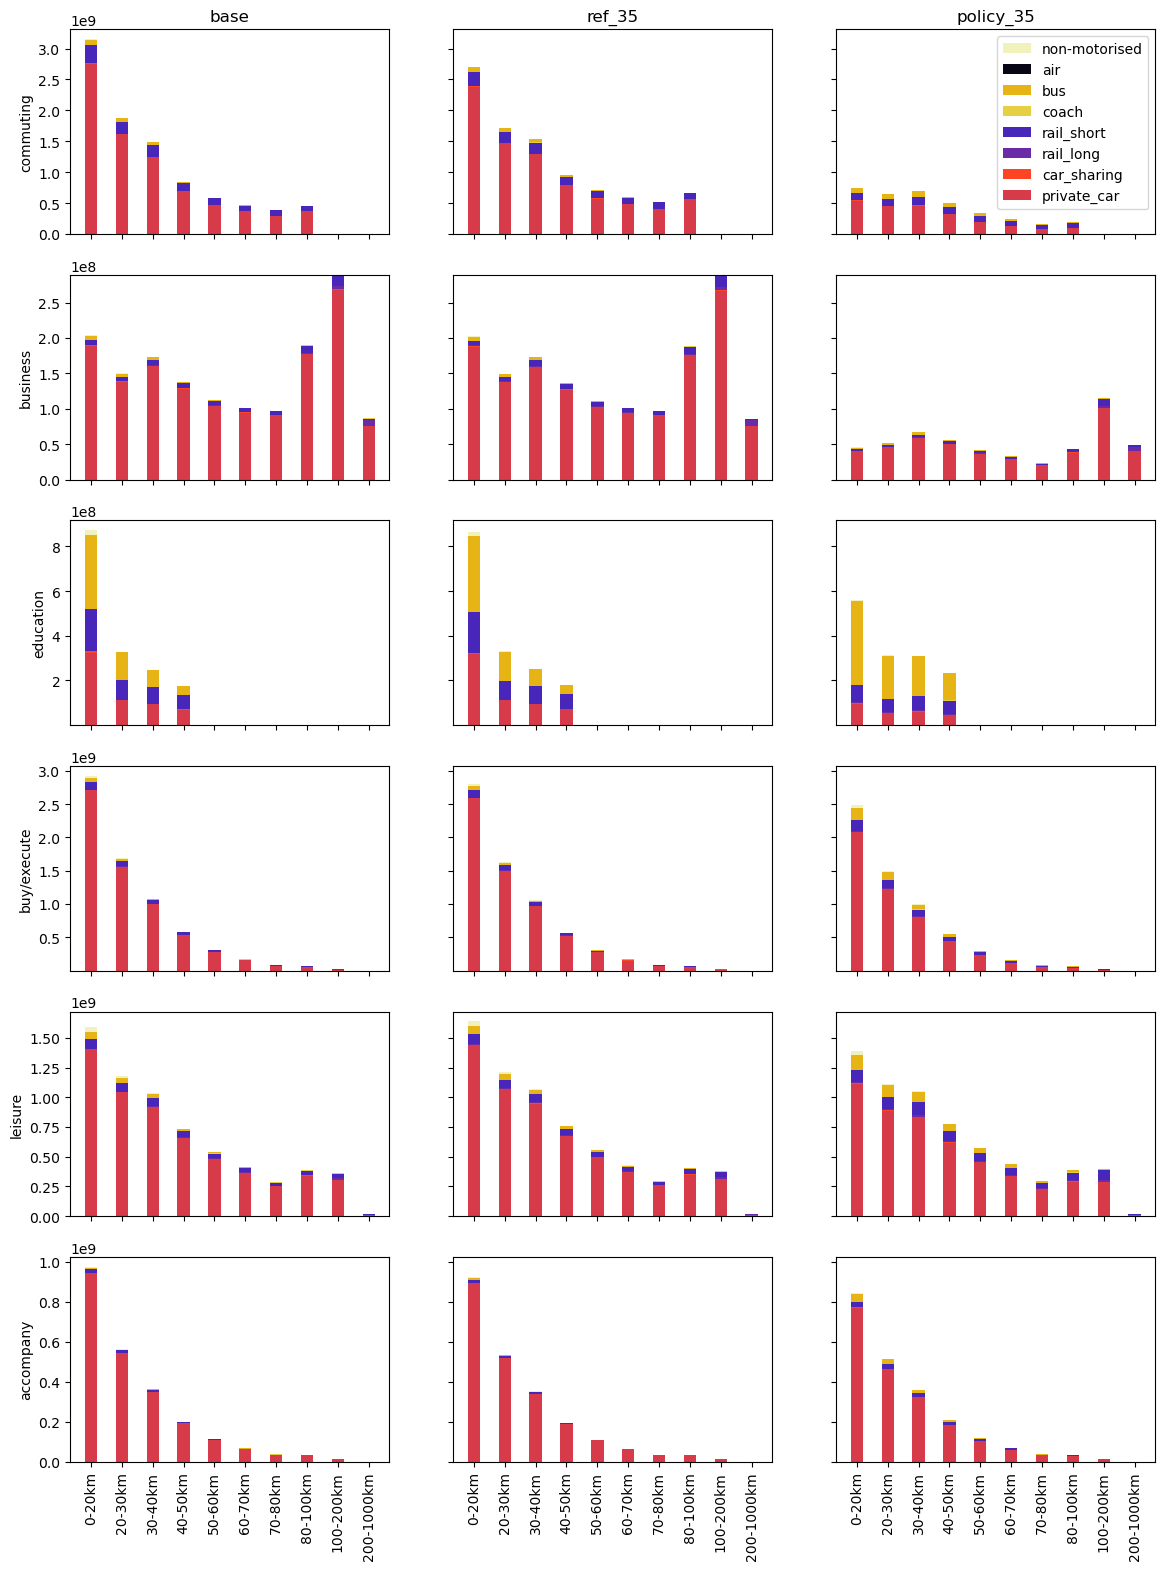

In [35]:
# Bar plot with distance distribution and mode shares
# max. dimensions: 14x19.5
fig, ax = plt.subplots(nrows=len(purposes), ncols=len(scenarios), figsize=(14,len(purposes)*3.1),
                       sharex='col', sharey='row')
j = 0
width = 0.4
ind = np.arange(len(labels))
for scenario in scenarios:
    for i in range(len(purposes)):
        od = ods[scenario].groupby('bins').sum().swaplevel(0,1, axis=1)[
            [s for s in segments if purposes[i] in s]
        ].stack('route_type').sum(axis=1).unstack('route_type').rename(
            columns={'walk': 'non-motorised'})
        modes = [m for m in colormap.keys() if m in od.columns]
        od = od[modes]
        for m in range(len(modes)):
            ax[i,j].bar(ind+width_filled, od[modes[m]].values,
                        bottom=od.iloc[:, :m].sum(axis=1).values if m>0 else 0,
                        width=width, tick_label=labels,
                        color=colormap[modes[m]],
                        label=modes[m])
        ax[i,0].set_ylabel(purposes[i])
    ax[0,j].set_title(scenario)
    ax[-1,j].tick_params(axis="x", rotation=90)
    j += 1
h, l = ax[-2,0].get_legend_handles_labels()
ax[0,-1].legend([h[l.index(m)] for m in colormap.keys() if m in l][::-1],
                [m for m in colormap.keys() if m in l][::-1])
plt.savefig(output_path + '_scenario_validation/modal_split_distance_segmented.png',
            dpi=dpi, bbox_inches="tight")

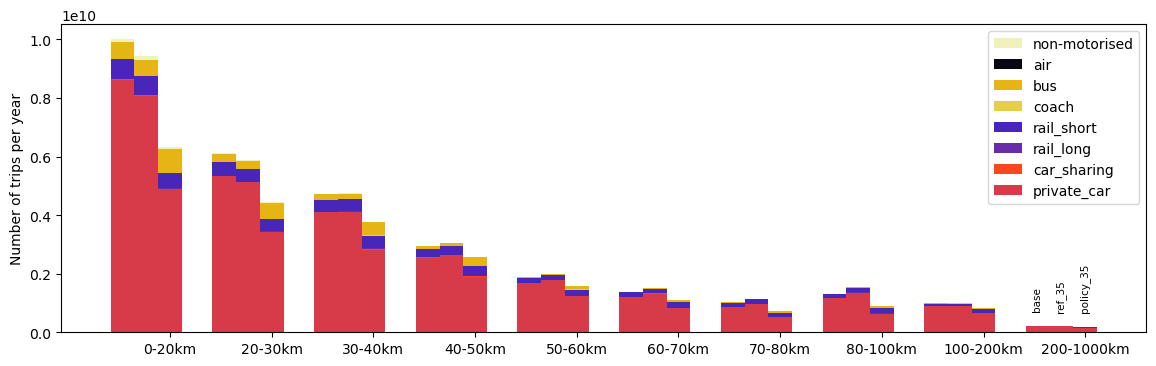

In [36]:
# Bar plot with distance distribution - total
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,4))
width_filled = 0
width = 1/len(scenarios) - 0.1
ind = np.arange(len(labels))
for scenario in scenarios:
    od = ods[scenario].stack('segment').fillna(method='bfill').\
        groupby('bins').sum().reindex(labels).rename(
            columns={'walk': 'non-motorised'})
    modes = [m for m in colormap.keys() if m in od.columns]
    od = od[modes]
    for m in range(len(modes)):
        ax.bar(ind+width_filled, od[modes[m]].values,
               bottom=od.iloc[:, :m].sum(axis=1).values if m>0 else 0,
               width=width, tick_label=labels,
               color=colormap[modes[m]],
               label=modes[m])#+' '+scenario)
    ax.annotate(scenario, xy=(width_filled+ind[-1]-width/4, 8e8),
                rotation=90, fontsize=7.5)
    width_filled += width
ax.set_ylabel('Number of trips per year')
h, l = ax.get_legend_handles_labels()
ax.legend([h[l.index(m)] for m in colormap.keys() if m in l][::-1],
          [m for m in colormap.keys() if m in l][::-1])
plt.savefig(output_path + '_scenario_validation/modal_split_distance_total.png',
            dpi=dpi, bbox_inches="tight")

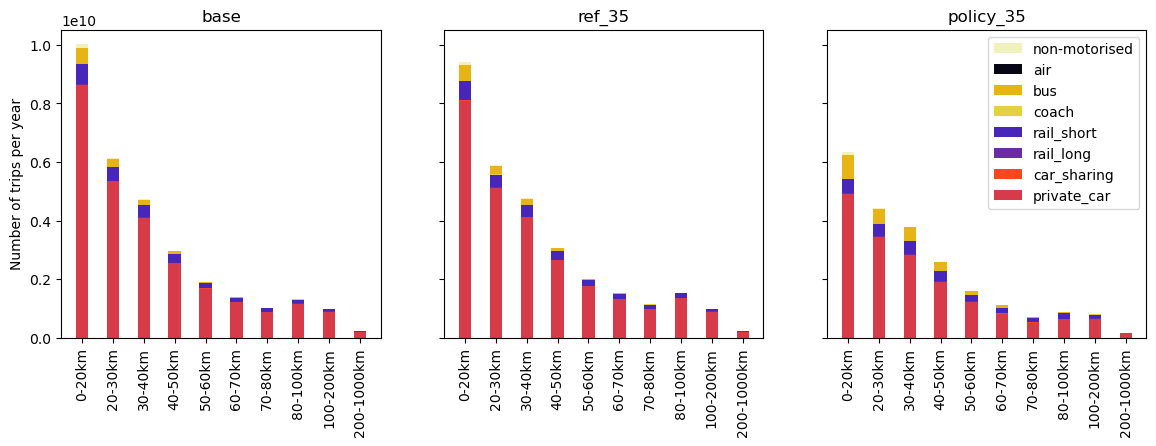

In [37]:
# Bar plot with distance distribution - total
fig, ax = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(14,4),
                       sharex='col', sharey='row')
width = 0.4
ind = np.arange(len(labels))
i = 0
for scenario in scenarios:
    od = ods[scenario].stack('segment').fillna(method='bfill').\
        groupby('bins').sum().reindex(labels).rename(
            columns={'walk': 'non-motorised'})
    modes = [m for m in colormap.keys() if m in od.columns]
    od = od[modes]
    for m in range(len(modes)):
        ax[i].bar(ind+width_filled, od[modes[m]].values,
                  bottom=od.iloc[:, :m].sum(axis=1).values if m>0 else 0,
                  width=width, tick_label=labels,
                  color=colormap[modes[m]],
                  label=modes[m])
    ax[i].set_title(scenario)
    ax[i].tick_params(axis="x", rotation=90)
    i += 1
ax[0].set_ylabel('Number of trips per year')
h, l = ax[0].get_legend_handles_labels()
ax[-1].legend([h[l.index(m)] for m in colormap.keys() if m in l][::-1],
             [m for m in colormap.keys() if m in l][::-1])
plt.savefig(output_path + '_scenario_validation/modal_split_distance_total.png',
            dpi=dpi, bbox_inches="tight")

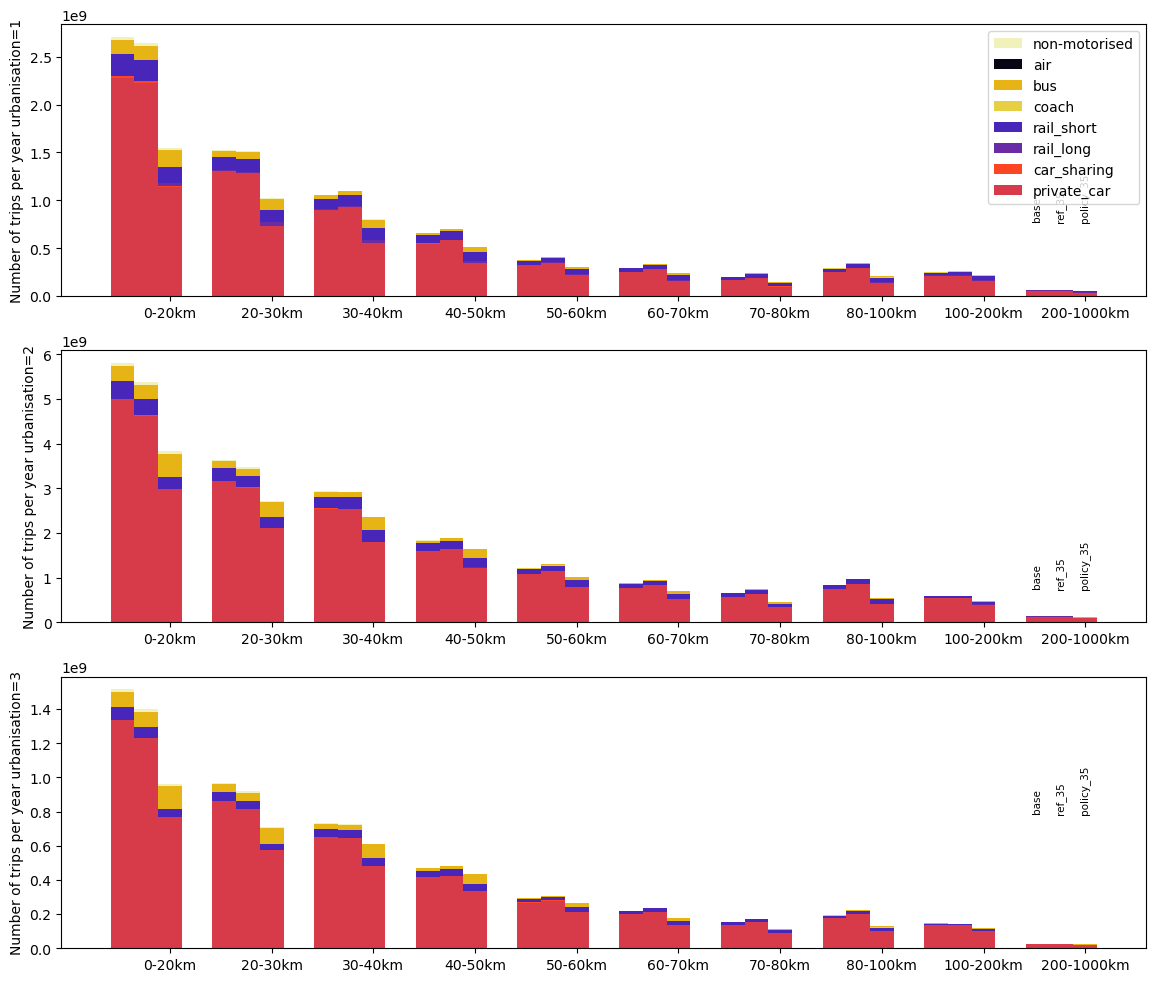

In [38]:
# Bar plot with distance distribution - by urbanisation
urbanisations = set(ref.zones['urbanisation'])
fig, ax = plt.subplots(nrows=len(urbanisations), ncols=1, figsize=(14,4*len(urbanisations)))
width_filled = 0
width = 1/len(scenarios) - 0.1
ind = np.arange(len(labels))
for scenario in scenarios:
    for u in urbanisations:
        origins = ref.zones.loc[ref.zones['urbanisation']==u].index
        od = ods[scenario].loc[ods[scenario].index.get_level_values(0).isin(origins)].\
            stack('segment').fillna(method='bfill').\
            groupby('bins').sum().reindex(labels).rename(
                columns={'walk': 'non-motorised'})
        modes = [m for m in colormap.keys() if m in od.columns]
        od = od[modes]
        for m in range(len(modes)):
            ax[u-1].bar(ind+width_filled, od[modes[m]].values,
                       bottom=od.iloc[:, :m].sum(axis=1).values if m>0 else 0,
                       width=width, tick_label=labels,
                       color=colormap[modes[m]],
                       label=modes[m])#+' '+scenario)
        ax[u-1].annotate(scenario, xy=(width_filled+ind[-1]-width/4, 8e8),
                         rotation=90, fontsize=7.5)
        ax[u-1].set_ylabel('Number of trips per year urbanisation={}'.format(u))
    width_filled += width
h, l = ax[0].get_legend_handles_labels()
ax[0].legend([h[l.index(m)] for m in colormap.keys() if m in l][::-1],
             [m for m in colormap.keys() if m in l][::-1])

# Passenger kilometre

pkm = #trips * distance

Take network loads (not main mode)

In [39]:
# Load pkm
pkm = {}
for s in scenarios:
    df = pd.read_csv(output_path + s + '/pkm.csv')
    df = df.set_index(['origin', 'mode']).unstack('mode')['pkm'].dropna(how='all').fillna(0)
    pkm[s] = df[[mode for mode in df.columns if df[mode].sum()>df.sum().sum()*0.001]]

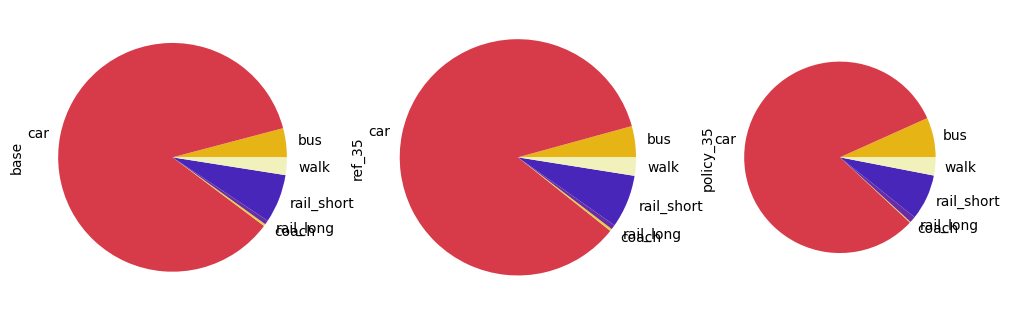

In [40]:
# Pkm mode shares
# Pie size represents total pkm
all_sum = sum([pkm[s].sum().sum() for s in scenarios])
fig, ax = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(len(scenarios)*4,4),
                       gridspec_kw={'width_ratios':
                                    [pkm[s].sum().sum() / all_sum for s in scenarios]
                                   })
for i in range(len(scenarios)):
    pkm[scenarios[i]].sum().plot.pie(ax=ax[i], ylabel=scenarios[i],
                                     colors=[colormap[m] for m in pkm[scenarios[i]].rename(
                                         columns={'walk': 'non-motorised'}).columns])

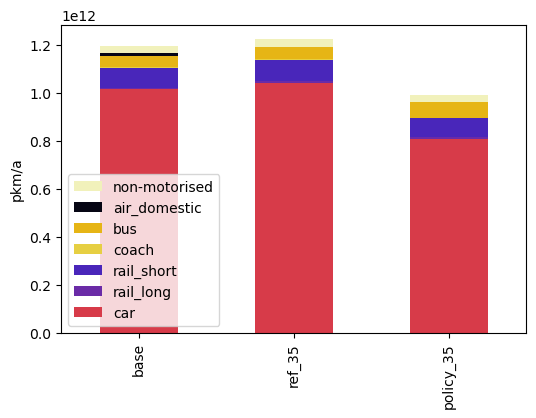

In [41]:
# Pkm as bar plot
fig, ax = plt.subplots(figsize=(6,4))
pkm_df = pd.DataFrame()
for s in scenarios:
    pkm_df[s] = pkm[s].sum()
pkm_df.loc['air_domestic', scenario_ref] = 10.4e9
pkm_df = pkm_df.rename(index={'walk': 'non-motorised'}).fillna(0)
modes = [m for m in colormap.keys() if m in pkm_df.index]
pkm_df.T[modes].plot.bar(stacked=True, ax=ax, legend=None,
                         color=[colormap[m] for m in modes])
ax.set_ylabel('pkm/a')
h,l = ax.get_legend_handles_labels()
plt.legend(h[::-1], l[::-1], loc='lower left')
plt.savefig(output_path + '_scenario_validation/modal_split_pkm.png', dpi=dpi, bbox_inches = "tight")

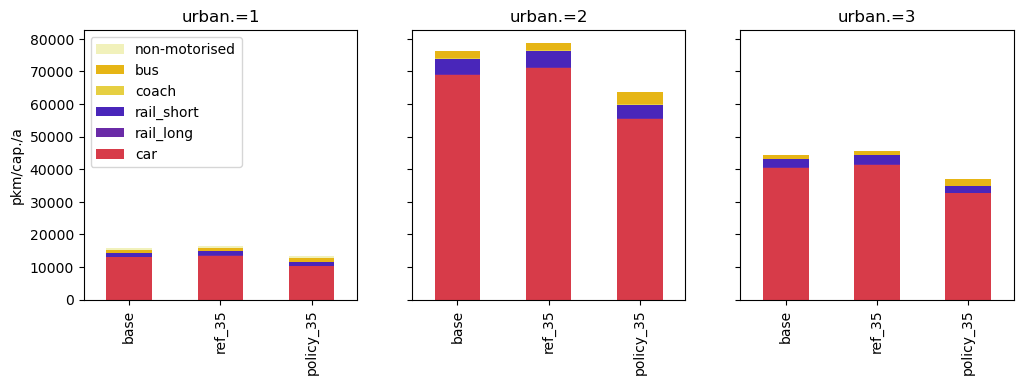

In [42]:
# Pkm as bar plot by urbanisation
urb = list(ref.zones['urbanisation'].unique())
urb.sort()
fig, ax = plt.subplots(nrows=1, ncols=len(urb), figsize=(4*len(urb),3.5), sharey='all')
pkm_df_pop = pd.DataFrame()
for u in urb:
    zones = list(ref.zones.loc[ref.zones['urbanisation']==u, 'NUTS_ID'])
    for s in scenarios:
        pkm_df_pop[s] = pkm[s].loc[zones].sum() \
            / ref.zones.loc[ref.zones['NUTS_ID'].isin(zones), 'population'].sum()
    pkm_df_pop = pkm_df_pop.rename(index={'walk': 'non-motorised'}).fillna(0)
    modes = [m for m in colormap.keys() if m in pkm_df_pop.index]
    pkm_df_pop.T[modes].plot.bar(stacked=True, ax=ax[u-1], legend=None,
                                 color=[colormap[m] for m in modes])
    ax[u-1].set_title('urban.={}'.format(u))
ax[0].set_ylabel('pkm/cap./a')
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1], loc='upper left')

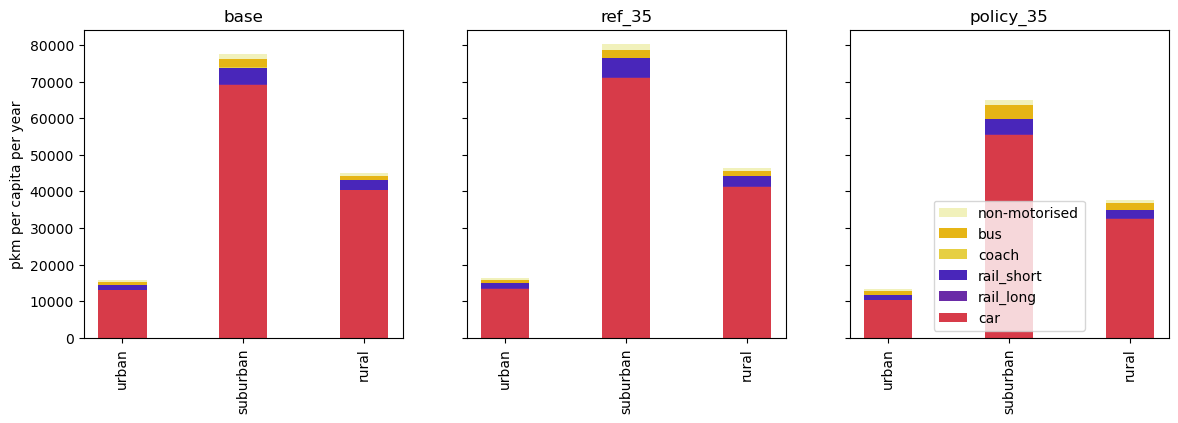

In [43]:
# Pkm as bar plot by urbanisation
fig, ax = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(14,4),
                       sharex='col', sharey='row')
width = 0.4
ind = np.arange(len(urb))
i = 0
for scenario in scenarios:
    df = pd.DataFrame()
    for u in urb:
        zones = list(ref.zones.loc[ref.zones['urbanisation']==u, 'NUTS_ID'])
        df[u] = pkm[scenario].loc[zones].sum() \
            / ref.zones.loc[ref.zones['NUTS_ID'].isin(zones), 'population'].sum()
    df = df.rename(index={'walk': 'non-motorised'})
    modes = [m for m in colormap.keys() if m in df.index]
    df = df.fillna(0).T[modes]
    for m in range(len(modes)):
        ax[i].bar(ind, df[modes[m]].values,
                  bottom=df.iloc[:, :m].sum(axis=1).values if m>0 else 0,
                  width=width, tick_label=['urban', 'suburban', 'rural'],
                  color=colormap[modes[m]],
                  label=modes[m])
    ax[i].set_title(scenario)
    ax[i].tick_params(axis="x", rotation=90)
    i += 1
ax[0].set_ylabel('pkm per capita per year')
h, l = ax[0].get_legend_handles_labels()
ax[-1].legend([h[l.index(m)] for m in colormap.keys() if m in l][::-1],
             [m for m in colormap.keys() if m in l][::-1])
plt.savefig(output_path + '_scenario_validation/pkm_urbanisation.png',
            dpi=dpi, bbox_inches="tight")

### Energy demand

Energy intensities depend on the transport technology and its propulsion system. There  are the following data sets available:
* TREMOD (Transport Emission Model; underlying values come from HBEFA (Handbuch Emissionsfaktoren)): "Aktualisierung der Modelle TREMOD/TREMOD-MM für die Emissionsberichterstattung 2020 (Berichtsperiode 1990-2018)", 2020
* better overview of TREMOD data for today here: https://www.umweltbundesamt.de/daten/verkehr/endenergieverbrauch-energieeffizienz-des-verkehrs#spezifischer-energieverbrauch-sinkt
* Easy diagrams for today here: https://www.allianz-pro-schiene.de/presse/pressemitteilungen/ferienstart-im-umweltvergleich-liegt-die-bahn-vorn/
* Projections for 2050 (choosing figures for fully electrified drivetrains): Robinius, M. et al. (2020). Kosteneffiziente und Klimagerechte Transformationsstrategien für das deutsche Energiesystem bis zum Jahr 2050. Jülich.
* Maximum efficiency assumptions for 2050: Millward-Hopkins, J., Steinberger, J. K., Rao, N. D., & Oswald, Y. (2020). Providing decent living with minimum energy: A global scenario. Global Environmental Change, 65, 102168. https://doi.org/10.1016/j.gloenvcha.2020.102168

None of the sources provides a comprehensive picture. The final energy demand ist of interest (without conversion losses in the energy supply chain).

In [44]:
# final energy demands in kWh/pkm
intensity = pd.DataFrame(index=['air_domestic', 'air_international',
                                'bus', 'car', 'coach', 'rail_long', 'rail_short',
                                'non-motorised'],
                         data={'2020': [# From UBA TREMOD
                                        2.76/3.6,
                                        2.5/3.6,
                                        0.9/3.6,
                                        2.14/3.6,
                                        0.41/3.6,
                                        0.51/3.6,
                                        0.86/3.6,
                                        0],
                               '2050': [2.76/3.6, # from today
                                        2.5/3.6, # from today
                                        # From Robinius et al. (2020) [kWh/pkm]
                                        1/10.626, # Battery-electric bus
                                        1/7.143, # BEV with occ=1.5 --> adjust to scenario
                                        1/10.626, # Battery-electric bus
                                        1/23.419, # Electric train
                                        1/23.419, # Electric train
                                        0],
                               '2050_eff': [# From Millward-Hopkins et al. (2020) [MJ/pkm-->kWh/pkm]
                                            0.98/3.6,
                                            0.98/3.6,
                                            0.18/3.6,
                                            0.35/3.6,
                                            0.18/3.6,
                                            0.06/3.6,
                                            0.06/3.6,
                                            0]
                              })

In [45]:
# Calculate energy demand
scaler = 1e9
demand = pd.DataFrame()
for s in scenarios:
    demand[s] = pkm_df[s] * intensity['2050'] / scaler
    params = excel.read_var(file='../input/parameters.xls', scenario=s)
    demand.loc['car', s] /= params['car_occ']['all'] / 1.5
demand = demand.fillna(0)

In [46]:
# Energy demand lowering potential
demand.sum() / demand[scenario_ref].sum()

base         1.000000
ref_35       0.977047
policy_35    0.775064
dtype: float64

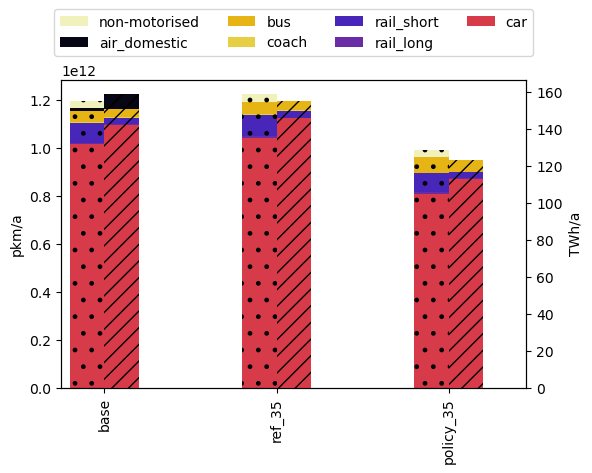

In [47]:
# Plot pkm and energy together
fig, ax1 = plt.subplots(figsize=(6,4))
width = 0.2
modes = [m for m in colormap.keys() if m in pkm_df.index]
pkm_df.T[modes].plot.bar(stacked=True, ax=ax1, legend=None,
                         color=[colormap[m] for m in modes],
                         width=width, position=1)
ax1.set_ylabel('pkm/a')
ax2 = ax1.twinx()
modes = [m for m in colormap.keys() if m in demand.index and m!='non-motorised']
demand.T[modes].plot.bar(stacked=True, ax=ax2, legend=None,
                         color=[colormap[m] for m in modes],
                         width=width, position=0)
ax2.set_ylabel('TWh/a')
h,l = ax1.get_legend_handles_labels()
plt.legend(h[::-1], l[::-1], loc='upper left', bbox_to_anchor=(-0.03, 1.25), ncol=4)
bars1 = ax1.patches
for bar in bars1:
    bar.set_hatch('.')
bars2 = ax2.patches
for bar in bars2:
    bar.set_hatch('//')
plt.savefig(output_path + '_scenario_validation/modal_split_energy_demand_pkm.png', dpi=dpi,
            bbox_inches="tight")

In [48]:
# Compare to
# - 2050 global sufficiency scenario from Millward-Hopkins et al. 2020
pop = 80103978
pkm_millward_hop = pd.Series({'air_domestic': 0,
                             'air_international': 0,#1067*pop,
                             'bus': 2714/2*pop,
                             'car': 679*pop,
                             'coach': 0,
                             'rail_long': (2714-2000)/2*pop,
                             'rail_short': 1000*pop,
                             'non-motorised': 1251*pop})
demand_comp = demand.copy()
demand_comp['Millward-Hopkins\n et al. 2020 Germany'
           ] = pkm_millward_hop * intensity['2050'] / scaler
demand_comp.sum()

base                                      158.606560
ref_35                                    154.966012
policy_35                                 122.930167
Millward-Hopkins\n et al. 2020 Germany     22.485838
dtype: float64

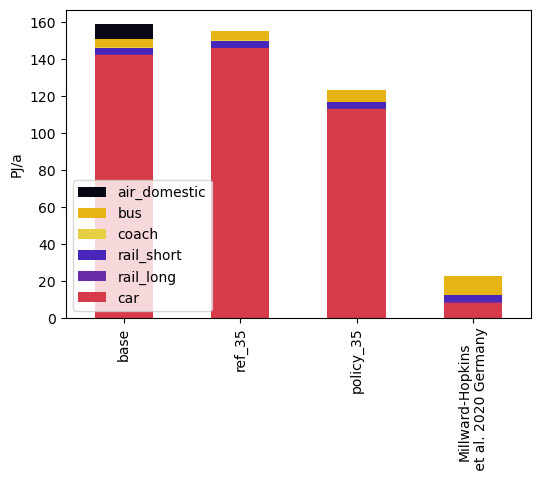

In [49]:
# energy demand compared
fig, ax = plt.subplots(figsize=(6,4))
modes = [m for m in colormap.keys() if m in demand.index and m!='non-motorised']
demand_comp.T[modes].plot.bar(stacked=True, ax=ax, legend=None,
                              color=[colormap[m] for m in modes])
ax.set_ylabel('PJ/a')
h,l = ax.get_legend_handles_labels()
plt.legend(h[::-1], l[::-1], loc='lower left')
plt.savefig(output_path + '_scenario_validation/energy_demand_compared.png', dpi=dpi,
            bbox_inches="tight")

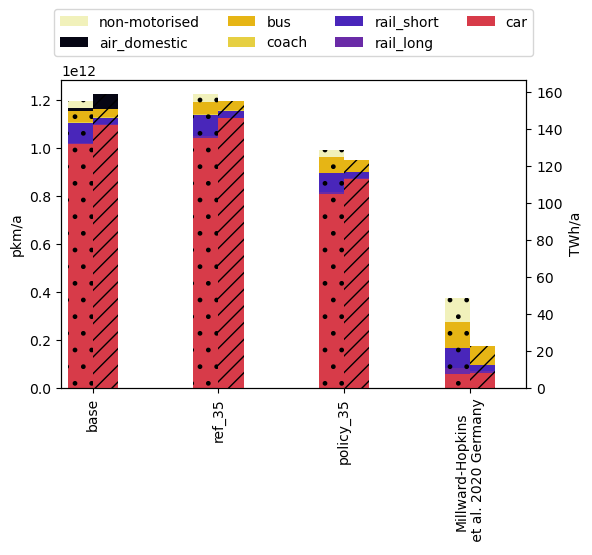

In [50]:
# Plot pkm and energy together, compared to comparison
fig, ax1 = plt.subplots(figsize=(6,4))
width = 0.2
pkm_comp = pkm_df.copy()
pkm_comp['Millward-Hopkins\n et al. 2020 Germany'] = pkm_millward_hop
modes = [m for m in colormap.keys() if m in pkm_df.index]
pkm_comp.T[modes].plot.bar(stacked=True, ax=ax1, legend=None,
                           color=[colormap[m] for m in modes],
                           width=width, position=1)
ax1.set_ylabel('pkm/a')
ax2 = ax1.twinx()
modes = [m for m in colormap.keys() if m in demand.index and m!='non-motorised']
demand_comp.T[modes].plot.bar(stacked=True, ax=ax2, legend=None,
                              color=[colormap[m] for m in modes],
                              width=width, position=0)
ax2.set_ylabel('TWh/a')
h,l = ax1.get_legend_handles_labels()
plt.legend(h[::-1], l[::-1], loc='upper left', bbox_to_anchor=(-0.03, 1.25), ncol=4)
bars1 = ax1.patches
for bar in bars1:
    bar.set_hatch('.')
bars2 = ax2.patches
for bar in bars2:
    bar.set_hatch('//')
plt.savefig(output_path + '_scenario_validation/modal_split_energy_demand_pkm_compared.png',
            dpi=dpi, bbox_inches="tight")

## Regional differences

In [52]:
# Prepare zones to plot
zones = ref.zones.groupby('NUTS_ID').agg({'geometry': lambda g: g.unary_union,
                                          'population': 'sum', 'area': 'sum'})
zones = zones.set_geometry("geometry")
zones = zones.set_crs(ref.epsg).to_crs(3857)

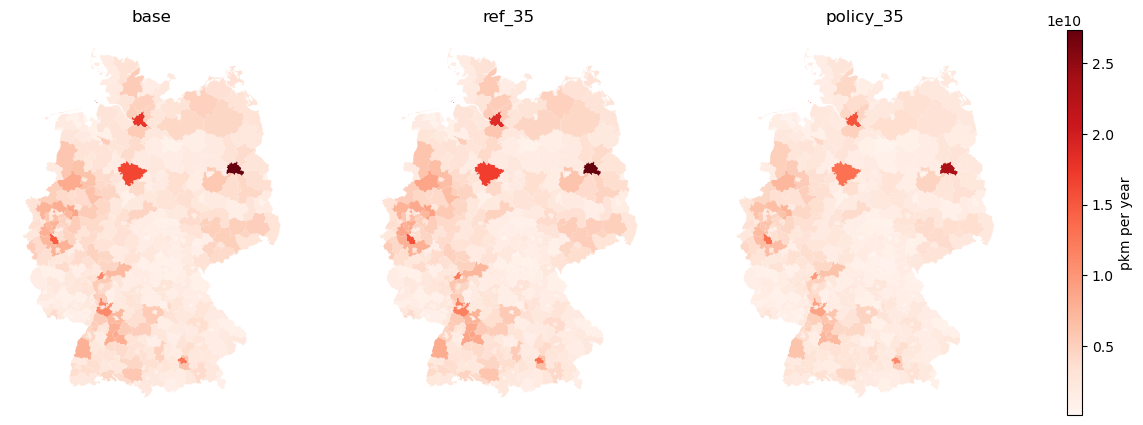

In [53]:
# Map the traffic intensity
# Grey areas are not modelled due to random sampling of OD pairs
fig, ax = plt.subplots(nrows=1, ncols=len(scenarios)+1, figsize=(14, 5),
                       gridspec_kw={'width_ratios': [len(scenarios)/(1-0.17)]*len(scenarios)+[0.17]})
vmin = 0
vmax = 0
for i in range(len(scenarios)):
    zones[scenarios[i]] = zones.merge(pkm[scenarios[i]].sum(axis=1).rename('pkm'),
                                      how='right', left_index=True, right_index=True)['pkm']
    if i == 0:
        vmax = zones[scenarios[i]].max()
        vmin = zones[scenarios[i]].min()
    plot = zones.plot(column=scenarios[i], colormap='Reds', missing_kwds={'color': 'lightgrey'},
                      vmin=vmin, vmax=vmax, legend=False, ax=ax[i])
    ax[i].set_title(scenarios[i])
    ax[i].set_axis_off()
fig.colorbar(ax[0].collections[0], cax=ax[-1], label="pkm per year")
plt.savefig(output_path + '_scenario_validation/map_pkm.png', dpi=dpi, bbox_inches="tight")

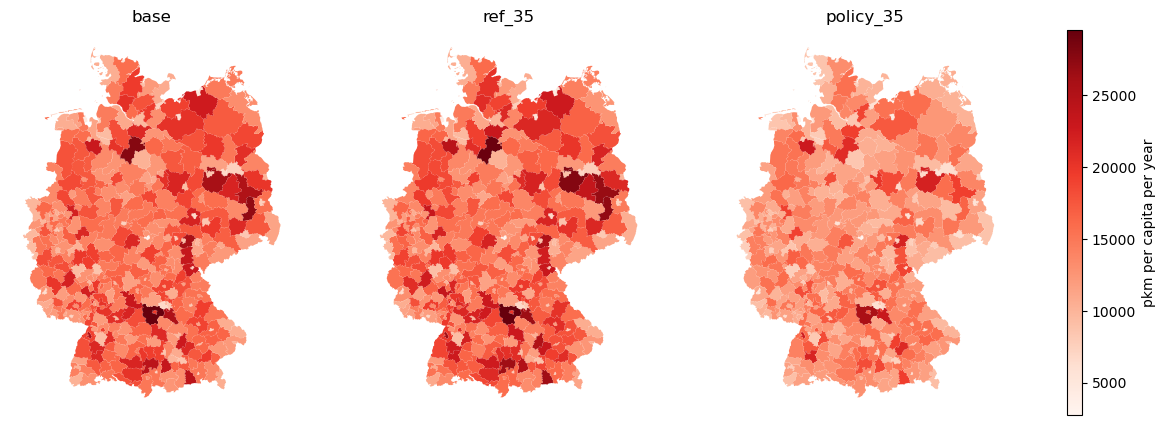

In [54]:
# Map the traffic intensity divided by population
fig, ax = plt.subplots(nrows=1, ncols=len(scenarios)+1, figsize=(14, 5),
                       gridspec_kw={'width_ratios': [len(scenarios)/(1-0.17)]*len(scenarios)+[0.17]})
vmin = 0
vmax = 0
for i in range(len(scenarios)):
    zones[scenarios[i]] = zones.merge(pkm[scenarios[i]].sum(axis=1).rename('pkm'),
                                      how='right', left_index=True, right_index=True)['pkm']
    zones[scenarios[i]] /= zones['population']
    if i == 0:
        vmax = zones[scenarios[i]].max()
        vmin = zones[scenarios[i]].min()
    plot = zones.plot(column=scenarios[i], colormap='Reds', missing_kwds={'color': 'lightgrey'},
                      vmin=vmin, vmax=vmax, legend=False, ax=ax[i])
    ax[i].set_title(scenarios[i])
    ax[i].set_axis_off()
fig.colorbar(ax[0].collections[0], cax=ax[-1], label="pkm per capita per year")
plt.savefig(output_path + '_scenario_validation/map_pkm_population.png', dpi=dpi, bbox_inches="tight")

### Street traffic load

In [55]:
# Load assigned road networks
roads = {}
for s in scenarios:
    sm = stepmodel.read_zippedpickles(model_path + s + '/de_assignment')
    roads[s] = gpd.GeoDataFrame(sm.road_links.loc[sm.road_links['volume']>1], crs=ref.epsg)
    del sm

road_links: 100%|█████████████████████████████████| 3/3 [00:01<00:00,  1.65it/s]


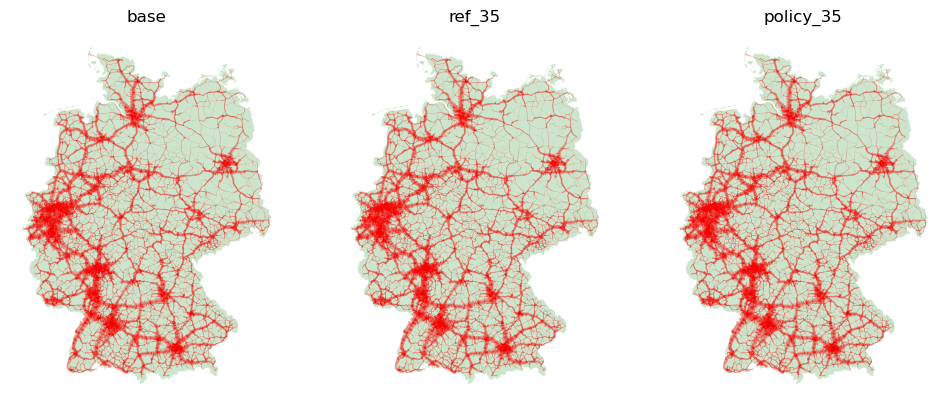

In [56]:
# Map the road traffic
fig, ax = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(len(scenarios)*4, 5))
scaler = 6e6
for i in range(len(scenarios)):
    roads[s] = roads[s].to_crs(zones.crs)
    roads[s].plot(alpha=.3, color='red', linewidth=list(roads[s]['volume']/scaler),
                  ax=zones.plot(alpha=.2, color='green', ax=ax[i]))
    ax[i].set_title(scenarios[i])
    ax[i].set_axis_off()

In [57]:
# Average mileage
car_use = {'Average annual mileage': [], 'Private cars owned (mio.)': []}
for s in scenarios:
    params = excel.read_var(file='../input/parameters.xls', scenario=s)
    car_use['Average annual mileage'].append(
        np.round((roads[s]['volume']*roads[s]['length']/1000).sum()
                 / params['car_occ']['all'] / params['vehicles']['car'], -2))
    car_use['Private cars owned (mio.)'].append(np.round(params['vehicles']['car'] / 1e6, 1))
pd.DataFrame(index=scenarios, data=car_use)#.to_latex()

Average annual mileage  Private cars owned (mio.)
base                      13000.0                       46.0
ref_35                    13500.0                       46.0
policy_35                  8200.0                       46.0